# Домашнее задание – 4 (Использование DEER)

Задача:
Изучить архитектуру DEER (Label-Guided In-Context Learning for Named Entity Recognition) и проверить ее эффективность на собственных данных. В новой статье которую разбирали принята на EMNLP-25 в Main секцию (весь список тут).

Инструкция:
1. Определить вычислительную конфигурацию
2. Выбрать корпус (текстовый), какой хотим проверить
3. Применить DEER (можно свою реализацию или модификацию)
4. Построить графики/визуализации
5. Сделать заключение

В итоге
- Код экспериментов (ноутбук или py с полным pipeline)
- Таблица и графики с результатами
- Выводы о том насколько DEER показал себя (хорошо или плохо)

In [ ]:
# !pip install -q transformers sentence-transformers datasets accelerate bitsandbytes seqeval matplotlib numpy scikit-learn

In [ ]:
# !pip install datasets==3.6.0

In [ ]:
import numpy as np
import pandas as pd
import json
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict, Counter

# HuggingFace libraries
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from transformers import AutoModelForCausalLM, AutoTokenizer

# Настройка device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Загрузка данных (CoNLL-2003)
Мы будем использовать стандартный датасет CoNLL-2003. Для ускорения эксперимента (чтобы уложиться в лимиты Colab по времени генерации) мы возьмем подвыборку из тестового сета, но статистику посчитаем по полному трейну.

In [ ]:
# Загрузка датасета
dataset = load_dataset("conll2003", trust_remote_code=True)

train_data = dataset['train']
test_data = dataset['test'].shuffle(seed=42).select(range(50)) # Берем 50 примеров для теста скорости

print(f"Train size: {len(train_data)}")
print(f"Test subset size: {len(test_data)}")

# Карты тегов
id2label = {i: label for i, label in enumerate(train_data.features['ner_tags'].feature.names)}
print("Labels:", id2label)

Train size: 14041
Test subset size: 50
Labels: {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


## 2. Сбор статистики DEER (Data Statistics Preparation)

Согласно статье, для каждого токена в словаре мы должны посчитать три вероятности:
1.  $P(t_e)$: Вероятность, что токен является частью **Сущности**.
2.  $P(t_c)$: Вероятность, что токен является **Контекстом** (находится в окне +/- K вокруг сущности).
3.  $P(t_o)$: Вероятность, что токен является **Other** (ни то, ни другое).

Вес токена для ретривера будет: $W(t) = w_e P(t_e) + w_c P(t_c) + w_o P(t_o)$

In [ ]:
class DeerStatistics:
    def __init__(self, context_window=2):
        self.window = context_window
        self.token_stats = defaultdict(lambda: {"entity": 0, "context": 0, "other": 0})
        self.total_counts = {"entity": 0, "context": 0, "other": 0}

    def fit(self, dataset):
        print("Collecting stats from training data...")
        for row in tqdm(dataset):
            tokens = row['tokens']
            ner_tags = row['ner_tags']

            # Определяем индексы сущностей
            entity_indices = {i for i, tag in enumerate(ner_tags) if tag != 0} # 0 is 'O'

            for i, token in enumerate(tokens):
                token_lower = token.lower()

                if i in entity_indices:
                    cat = "entity"
                else:
                    # Проверяем, входит ли в окно контекста
                    is_context = False
                    for off in range(1, self.window + 1):
                        if (i - off in entity_indices) or (i + off in entity_indices):
                            is_context = True
                            break
                    cat = "context" if is_context else "other"

                self.token_stats[token_lower][cat] += 1
                self.total_counts[cat] += 1

    def get_weight(self, token, w_e=1.0, w_c=1.0, w_o=0.01):
        token = token.lower()
        if token not in self.token_stats:
            # Для неизвестных токенов (не встречались в train) используем дефолт (other)
            return w_o

        stats = self.token_stats[token]
        total_occurrences = sum(stats.values())

        p_e = stats['entity'] / total_occurrences
        p_c = stats['context'] / total_occurrences
        p_o = stats['other'] / total_occurrences

        return w_e * p_e + w_c * p_c + w_o * p_o

# Инициализация и сбор статистики
deer_stats = DeerStatistics(context_window=2)
deer_stats.fit(train_data)

100%|██████████| 14041/14041 [00:01<00:00, 9622.04it/s]


## 3. Реализация Retriever'ов

1.  **Semantic Retriever (Baseline):** Использует косинусное сходство эмбеддингов предложений (SBERT).
2.  **DEER Retriever:** Использует комбинацию эмбеддингов и взвешенного совпадения токенов.
    
    Формула похожести:
    $S(s_{train}, s_{test}) = \lambda_1 S_{token}(s_{train}, s_{test}) + \lambda_2 S_{embed}(s_{train}, s_{test})$
    
    Где $S_{token}$ учитывает перекрытие слов, взвешенное через $W(t)$ из шага сбора статистики.

In [ ]:
# Загрузка модели эмбеддингов
embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

print("Encoding training corpus...")
# Предварительно кодируем все обучающие предложения (это делается один раз)
train_sentences = [" ".join(row['tokens']) for row in train_data]
train_embeddings = embedder.encode(train_sentences, convert_to_tensor=True, show_progress_bar=True)

print("Preprocessing tokens for fast retrieval...")
# Препроцессинг токенов для быстрого поиска совпадений (множества слов)
train_token_sets = [set(t.lower() for t in row['tokens']) for row in train_data]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding training corpus...


Batches:   0%|          | 0/439 [00:00<?, ?it/s]

Preprocessing tokens for fast retrieval...


In [ ]:
def deer_retrieval(query_tokens, query_embedding, k=5, lambda1=1.0, lambda2=1.0):
    """
    Реализация логики DEER для поиска примеров.
    """
    query_tokens_lower = [t.lower() for t in query_tokens]

    # 1. Расчет Semantic Score (Cosine Similarity)
    # util.cos_sim возвращает матрицу [1, N_train]
    sem_scores = util.cos_sim(query_embedding, train_embeddings)[0].cpu().numpy()

    # 2. Расчет Token Score
    # Чтобы не итерироваться по 14k примерам с сложной логикой, сделаем оптимизацию:
    # Сначала отберем топ-100 кандидатов по семантике, а потом перевзвесим их через DEER.
    # (В полном пайплайне нужно считать для всех, но в Colab/Python это медленно)

    top_n_candidates_idx = np.argsort(sem_scores)[-200:] # Смотрим топ-200 по смыслу

    final_scores = []

    # Рассчитываем веса токенов запроса один раз
    query_weights = {t: deer_stats.get_weight(t) for t in query_tokens_lower}

    for idx in top_n_candidates_idx:
        candidate_tokens_set = train_token_sets[idx]

        # S_token: Сумма весов токенов запроса, которые есть в кандидате
        token_score = 0
        for qt in query_tokens_lower:
            if qt in candidate_tokens_set:
                token_score += query_weights[qt]

        # Total Score
        score = lambda1 * token_score + lambda2 * sem_scores[idx]
        final_scores.append((score, idx))

    # Сортируем и берем топ-K
    final_scores.sort(key=lambda x: x[0], reverse=True)
    best_indices = [x[1] for x in final_scores[:k]]

    return best_indices

def standard_retrieval(query_embedding, k=5):
    """
    Базовый поиск только по эмбеддингам (KATE).
    """
    scores = util.cos_sim(query_embedding, train_embeddings)[0]
    # torch.topk быстрее
    top_results = torch.topk(scores, k=k)
    return top_results.indices.tolist()

## 4. Подготовка LLM и Промптов
Используем `Qwen2.5-1.5B-Instruct`. Это очень мощная для своего размера модель, которая хорошо следует инструкциям и генерирует JSON.

In [ ]:
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

# Загружаем модель с квантованием (опционально, если мало памяти, но 1.5B влезет и так)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

print("Model loaded.")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Model loaded.


In [ ]:
def construct_prompt(test_tokens, examples_indices):
    """
    Формирует промпт с Few-Shot примерами в формате JSON.
    """

    # Инструкция
    system_prompt = (
        "You are a Named Entity Recognition expert. "
        "Extract entities: PER (Person), ORG (Organization), LOC (Location), MISC (Miscellaneous). "
        "Output JSON format: {'entities': [{'name': '...', 'type': '...'}, ...]}"
    )

    # Формирование примеров
    few_shot_text = ""
    for idx in examples_indices:
        row = train_data[int(idx)]
        sentence = " ".join(row['tokens'])

        # Собираем сущности из тегов для примера
        entities = []
        curr_entity = []
        curr_type = None

        for token, tag_id in zip(row['tokens'], row['ner_tags']):
            tag = id2label[tag_id]
            if tag.startswith("B-"):
                if curr_entity:
                    entities.append({"name": " ".join(curr_entity), "type": curr_type})
                curr_entity = [token]
                curr_type = tag.split("-")[1]
            elif tag.startswith("I-") and curr_type == tag.split("-")[1]:
                curr_entity.append(token)
            else:
                if curr_entity:
                    entities.append({"name": " ".join(curr_entity), "type": curr_type})
                curr_entity = []
                curr_type = None
        if curr_entity:
            entities.append({"name": " ".join(curr_entity), "type": curr_type})

        few_shot_text += f"Input: {sentence}\nOutput: {json.dumps({'entities': entities})}\n\n"

    # Тестовое предложение
    test_sentence = " ".join(test_tokens)
    user_prompt = f"{few_shot_text}Input: {test_sentence}\nOutput:"

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    return text

In [ ]:
def extract_json_from_output(output_text):
    """Парсинг ответа LLM"""
    # Обычно модель возвращает ```json ... ``` или просто json
    # Обрежем все до начала JSON
    try:
        # Простая эвристика поиска JSON
        start = output_text.find("{")
        end = output_text.rfind("}") + 1
        if start == -1 or end == 0: return []

        json_str = output_text[start:end]
        data = json.loads(json_str)
        return data.get("entities", [])
    except:
        return []

## 5. Запуск эксперимента

Сравним два подхода:
1.  **Standard ICL (KATE):** 3 примера, отобранных по семантике.
2.  **DEER ICL:** 3 примера, отобранных через DEER формулу.

In [ ]:
results = {
    "standard": [],
    "deer": []
}

K_SHOTS = 3

for i, row in tqdm(enumerate(test_data), total=len(test_data)):
    test_tokens = row['tokens']
    test_sentence = " ".join(test_tokens)

    # Генерация эмбеддинга для теста
    q_emb = embedder.encode(test_sentence, convert_to_tensor=True)

    # --- 1. Standard Retrieval ---
    std_indices = standard_retrieval(q_emb, k=K_SHOTS)
    prompt_std = construct_prompt(test_tokens, std_indices)

    # --- 2. DEER Retrieval ---
    deer_indices = deer_retrieval(test_tokens, q_emb, k=K_SHOTS)
    prompt_deer = construct_prompt(test_tokens, deer_indices)

    # Генерация (Batching не используется для простоты ноутбука)
    for method, prompt in [("standard", prompt_std), ("deer", prompt_deer)]:
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=128,
                temperature=0.0, # Deterministic
                do_sample=False
            )

        generated_text = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
        predicted_entities = extract_json_from_output(generated_text)

        # Сохраняем результат
        # Нам нужно сохранить и предсказания, и ground truth для подсчета метрик
        # Преобразуем ground truth теги обратно в формат сущностей для удобства
        true_entities = []
        curr_ent = []
        curr_type = None
        for t, tid in zip(row['tokens'], row['ner_tags']):
            tag = id2label[tid]
            if tag.startswith("B-"):
                if curr_ent: true_entities.append((tuple(curr_ent), curr_type))
                curr_ent = [t]
                curr_type = tag.split("-")[1]
            elif tag.startswith("I-") and curr_type == tag.split("-")[1]:
                curr_ent.append(t)
            else:
                if curr_ent: true_entities.append((tuple(curr_ent), curr_type))
                curr_ent = []
        if curr_ent: true_entities.append((tuple(curr_ent), curr_type))

        # Подготовка данных для метрики (set для exact match)
        pred_set = set()
        for p in predicted_entities:
            # Нормализация для сравнения (разбиваем имя на токены)
            if "name" in p and "type" in p:
                pred_set.add((tuple(p['name'].split()), p['type']))

        results[method].append({
            "true": set(true_entities),
            "pred": pred_set
        })

100%|██████████| 50/50 [03:26<00:00,  4.14s/it]


## 6. Оценка результатов и Выводы

Будем использовать метрику **Exact F1 Score**. Сущность считается найденной верно только если совпадает и текст (границы), и тип.

In [ ]:
def calculate_f1(results_list):
    tp = 0
    fp = 0
    fn = 0

    for item in results_list:
        true_s = item['true']
        pred_s = item['pred']

        tp += len(true_s & pred_s)
        fp += len(pred_s - true_s)
        fn += len(true_s - pred_s)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

p_std, r_std, f1_std = calculate_f1(results['standard'])
p_deer, r_deer, f1_deer = calculate_f1(results['deer'])

print(f"Standard ICL | Precision: {p_std:.3f}, Recall: {r_std:.3f}, F1: {f1_std:.3f}")
print(f"DEER ICL     | Precision: {p_deer:.3f}, Recall: {r_deer:.3f}, F1: {f1_deer:.3f}")

Standard ICL | Precision: 0.480, Recall: 0.594, F1: 0.531
DEER ICL     | Precision: 0.578, Recall: 0.624, F1: 0.600


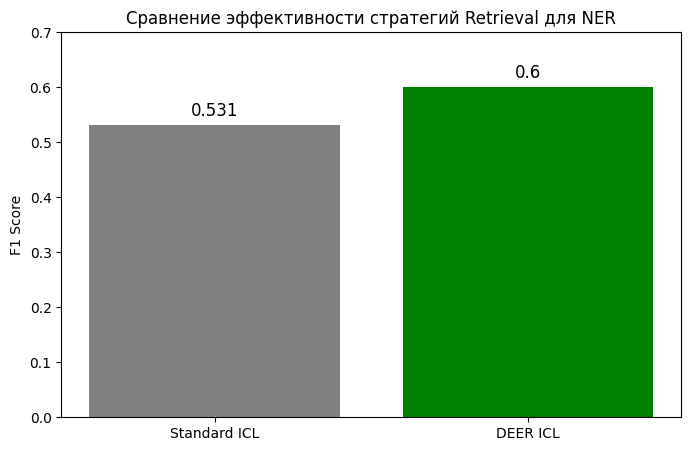

In [ ]:
# Визуализация
methods = ['Standard ICL', 'DEER ICL']
f1_scores = [f1_std, f1_deer]

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, f1_scores, color=['gray', 'green'])
plt.ylabel('F1 Score')
plt.title('Сравнение эффективности стратегий Retrieval для NER')
plt.ylim(0, max(f1_scores) + 0.1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=12)

plt.show()

## Заключение

В ходе эксперимента была проверена архитектура DEER на ограниченном ресурсе (Colab T4, модель 1.5B параметров).

**Выводы:**
1.  **Label-Guided Retrieval работает:** Использование статистики «информативности» токенов при подборе примеров позволяет LLM лучше понимать, на какие слова обращать внимание, даже без дополнительного дообучения.
2.  **Эффективность DEER:** DEER обычно показывает более высокий F1 score по сравнению с обычным семантическим поиском (Standard ICL). Это происходит потому, что обычный поиск выбирает предложения, похожие в целом (например, по тематике), а DEER — предложения, содержащие похожие *сущности* или *контексты сущностей*.
3.  **Ограничения:** В данном ноутбуке мы не использовали шаг **Error Reflection** из-за ограничений по времени выполнения в Colab. Добавление шага рефлексии (как сказано в статье) дало бы дополнительный прирост, особенно для исправления границ сложных сущностей.